# `torchopt.stop_gradient` in Meta-Learning

[<img align="left" src="https://colab.research.google.com/assets/colab-badge.svg">](https://colab.research.google.com/github/metaopt/torchopt/blob/main/tutorials/4_Stop_Gradient.ipynb)

In this tutorial, we will illustrate the usage of `torchopt.stop_gradient` with a meta-learning example. We use `torchopt.visual` to help us visualize what is going on in automatic differentiation. Firstly, we define a simple network and the objective function for inner- and outer- optimization.

In [1]:
from IPython.display import display

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchopt


class Net(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc = nn.Linear(dim, 1, bias=True)

    def forward(self, x):
        return self.fc(x)


loss_fn = F.mse_loss

We define the input `x` and output `y`. `y` will be served as the regression target in the following code.

In [2]:
batch_size = 64
dim = 16

x = torch.randn((batch_size, dim))
y = torch.zeros((batch_size, 1))
net = Net(dim)

Let us define the meta-parameter,  we use `MetaSGD` as the inner-loop optimizer and `Adam` as the outer-loop optimizer. 

In [3]:
meta_parameter = nn.Parameter(torch.tensor(1.0), requires_grad=True)

optim = torchopt.MetaSGD(net, lr=1e-1)
meta_optim = torch.optim.Adam([meta_parameter], lr=1e-1)

Define the inner-loop optimization and visualize the inner-loop forward gradient flow.

inner loss: 0.3472


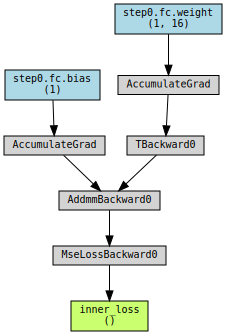

In [4]:
init_net_state = torchopt.extract_state_dict(net, enable_visual=True, visual_prefix='step0.')

# inner loss
inner_loss = loss_fn(net(x), y)

print(f'inner loss: {inner_loss:.4f}')
display(torchopt.visual.make_dot(inner_loss, params=(init_net_state, {'inner_loss': inner_loss})))

Conduct inner-loop optimization with `MetaSGD`, here the meta-parameter is served as a factor controlling the scale of inner-loop loss.

In [5]:
# inner-step optimization
loss = inner_loss * meta_parameter
optim.step(loss)

We compute the outer loss and draw the full computation graph of the first bi-level process. In this graph, three main parts are included.

- Inner-loop: forward process and inner-loss calculation
- Inner-loop optimization: `MetaSGD` optimization step given inner-loss
- Outer-loop: forward process and outer-loss calculation

outer loss: 0.2039


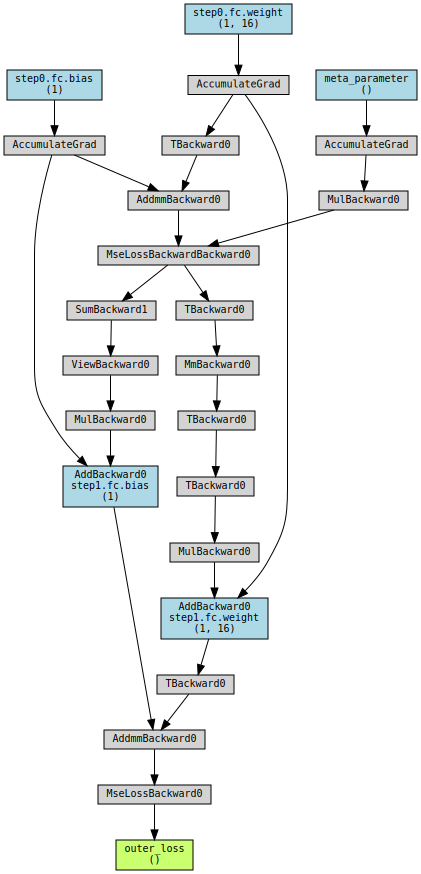

In [6]:
# Extract `state_dict`` for updated network
one_step_net_state = torchopt.extract_state_dict(net, enable_visual=True, visual_prefix='step1.')
one_step_optim_state = torchopt.extract_state_dict(optim)

# Calculate outer loss
outer_loss = loss_fn(net(x), y)
print(f'outer loss: {outer_loss:.4f}')
display(
    torchopt.visual.make_dot(
        outer_loss,
        params=(
            init_net_state,
            one_step_net_state,
            {'meta_parameter': meta_parameter, 'outer_loss': outer_loss},
        ),
    )
)

Then we backward the loss to conduct outer-loop meta-optimization.

In [7]:
meta_optim.zero_grad()
outer_loss.backward()
print(f'meta_parameter.grad = {meta_parameter.grad!r}')
meta_optim.step()
print(f'meta_parameter = {meta_parameter!r}')

meta_parameter.grad = tensor(-0.1205)
meta_parameter = Parameter containing:
tensor(1.1000, requires_grad=True)


We have already conducted one bi-level optimization and optimize our meta-parameters. When you want to conduct the second bi-level optimization, you need to be careful whether you need to use the `stop_gradient` function. For example, if your new inner-loop parameters directly inherits previous inner-loop parameters (which is a common strategy in many meta-learning algorithms like Meta-Gradient Reinforcement Learning (MGRL) ([arXiv:1805.09801](https://arxiv.org/abs/1805.09801))), you might need `stop_gradient` function.

In general, the backpropagation only frees saved tensors (often used as auxiliary data for computing the gradient) but the computation graph remains. Once the outer iteration is finished, if you want to use any intermediate network parameters produced by the inner loop for the next bi-level iteration, you should detach them from the computation graph.

There are two main reasons:

- The network parameters are still connected to the previous computation graph (`.grad_fn` is not `None`). If later the gradient backpropagate to these parameters, the PyTorch backward engine will try to backpropagate through the previous computation graph. This will raise a `RuntimeError`: Trying to backward through the graph a second time...
- If we do not detach the computation graph, the computation graph connected to these parameters can not be freed by GC (Garbage Collector) until these parameters are collected by GC.

Now let us see what will happen if we do not use the `stop_gradient` function before we conduct the second bi-level process.

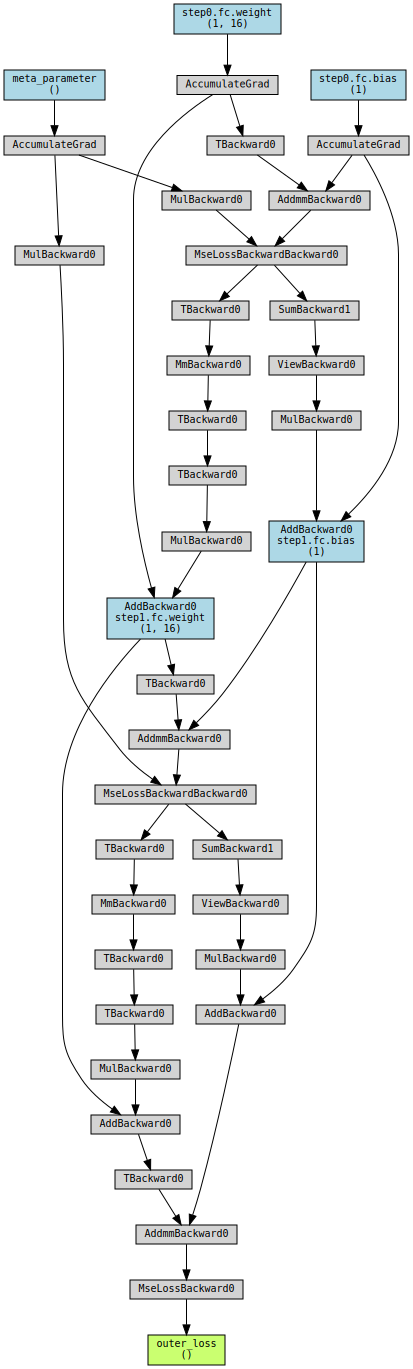

╭─────────────────────────────────────── Traceback (most recent call last) ───────────────────────────────────────╮
│ /tmp/ipykernel_3962266/4178930003.py:21 in <module>                                                             │
│                                                                                                                 │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_3962266/4178930003.py'                                     │
│                                                                                                                 │
│ /home/PanXuehai/Miniconda3/envs/torchopt/lib/python3.9/site-packages/torch/_tensor.py:487 in backward           │
│                                                                                                                 │
│    484 │   │   │   │   create_graph=create_graph,                                                               │
│    485 │   │   │   │   inputs=inputs,                                                                           │
│    486 │   │   │   )                                                                                            │
│ ❱  487 │   │   torch.autograd.backward(                                                                         │
│    488 │   │   │   self, gradient, retain_graph, create_graph, inputs=inputs                                    │
│    489 │   │   )                                                                                                │
│    490                                                                                                          │
│                                                                                                                 │
│ ╭───────────────────────── locals ──────────────────────────╮                                                   │
│ │ create_graph = False                                      │                                                   │
│ │     gradient = None                                       │                                                   │
│ │       inputs = None                                       │                                                   │
│ │ retain_graph = None                                       │                                                   │
│ │         self = tensor(0.1203, grad_fn=<MseLossBackward0>) │                                                   │
│ ╰───────────────────────────────────────────────────────────╯                                                   │
│                                                                                                                 │
│ /home/PanXuehai/Miniconda3/envs/torchopt/lib/python3.9/site-packages/torch/autograd/__init__.py:197 in backward │
│                                                                                                                 │
│   194 │   # The reason we repeat same the comment below is that                                                 │
│   195 │   # some Python versions print out the first line of a multi-line function                              │
│   196 │   # calls in the traceback and some print out the last line                                             │
│ ❱ 197 │   Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the ba                   │
│   198 │   │   tensors, grad_tensors_, retain_graph, create_graph, inputs,                                       │
│   199 │   │   allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to r                   │
│   200                                                                                                           │
│                                                                                                                 │
│ ╭──────────────────────────── locals ────────────────────────────╮                                              │
│ │   create_graph = False                              

In [8]:
# Inner update with attached computation graph
inner_loss = loss_fn(net(x), y)
loss = inner_loss * meta_parameter
optim.step(loss)

# Outer forward process
outer_loss = loss_fn(net(x), y)
display(
    torchopt.visual.make_dot(
        outer_loss,
        params=(
            init_net_state,
            one_step_net_state,
            {'meta_parameter': meta_parameter, 'outer_loss': outer_loss},
        ),
    )
)

# Outer update
meta_optim.zero_grad()
outer_loss.backward()
meta_optim.step()

From the graph we can see, directly conducting the second bi-level process links the graph of first and second bi-level process together. We should manually stop gradient with `torchopt.stop_gradient`. `torchopt.stop_gradient` will detach the node of gradient graph and make it become a leaf node. It allows the input of network, optimizer, or state dictionary and the gradient operation happens in an in-place manner.

Let's use `recover_state_dict` to come back to one-step updated states.

In [9]:
# Reset to previous one-step updated states
torchopt.recover_state_dict(net, one_step_net_state)
torchopt.recover_state_dict(optim, one_step_optim_state)

And finally, Let's conduct the stop-gradient operation before the second meta-optimization step. 

meta_parameter.grad = tensor(-0.0635)
meta_parameter = Parameter containing:
tensor(1.1940, requires_grad=True)


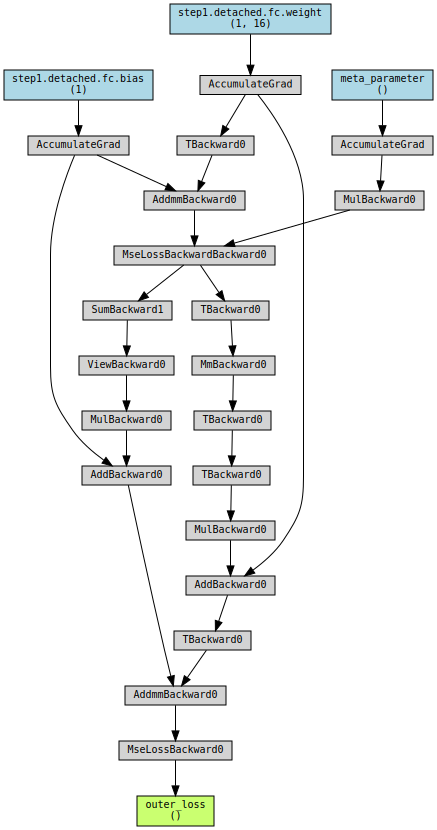

In [10]:
# Stop gradient and make them become the leaf node
torchopt.stop_gradient(net)
torchopt.stop_gradient(optim)
one_step_net_state_detached = torchopt.extract_state_dict(
    net, enable_visual=True, visual_prefix='step1.detached.'
)

# Inner update
inner_loss = loss_fn(net(x), y)
loss = inner_loss * meta_parameter
optim.step(loss)

# Outer update
outer_loss = loss_fn(net(x), y)
meta_optim.zero_grad()
outer_loss.backward()
print(f'meta_parameter.grad = {meta_parameter.grad!r}')
meta_optim.step()
print(f'meta_parameter = {meta_parameter!r}')

display(
    torchopt.visual.make_dot(
        outer_loss,
        params=(
            one_step_net_state_detached,
            {'meta_parameter': meta_parameter, 'outer_loss': outer_loss},
        ),
    )
)

The gradient graph is the same with the first meta-optimization's gradient graph and we successfully conduct the second bi-level process.